In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

In [2]:


DATA_PATH = '/content/drive/MyDrive/DATA_TRAIN_FINAL/DATA_TRAIN_SI/'

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=20):
      wave, sr = librosa.load(file_path, mono=True, sr=None)
      wave = wave[::3]
      mfcc = librosa.feature.mfcc(wave, sr=16000)

      # If maximum length exceeds mfcc lengths then pad the remaining ones
      if (max_len > mfcc.shape[1]):
          pad_width = max_len - mfcc.shape[1]
          mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

      # Else cutoff the remaining parts
      else:
          mfcc = mfcc[:, :max_len]
      
      return mfcc

def save_data_to_array(path=DATA_PATH, max_len=20):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        print(np.array(mfcc_vectors).shape)
        np.save(label + '.npy', mfcc_vectors)

def get_train_test(split_ratio=0.7, random_state=5):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset

import keras
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 20

# Save data to array file first
save_data_to_array(max_len= feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

Saving vectors of label - 'mười':   0%|          | 1/356 [00:00<00:37,  9.34it/s]

(828, 20, 20)


Saving vectors of label - 'một':   0%|          | 0/574 [00:00<?, ?it/s]

(356, 20, 20)


Saving vectors of label - 'hai':   0%|          | 0/633 [00:00<?, ?it/s]

(574, 20, 20)


Saving vectors of label - 'ba':   0%|          | 1/622 [00:00<01:09,  8.92it/s]

(633, 20, 20)


Saving vectors of label - 'sáu':   0%|          | 1/623 [00:00<01:04,  9.70it/s]

(622, 20, 20)


Saving vectors of label - 'bốn':   0%|          | 1/400 [00:00<00:42,  9.32it/s]

(623, 20, 20)


Saving vectors of label - 'chín':   0%|          | 1/649 [00:00<01:10,  9.16it/s]

(400, 20, 20)


Saving vectors of label - 'tám':   0%|          | 0/607 [00:00<?, ?it/s]

(649, 20, 20)


Saving vectors of label - 'bảy':   0%|          | 0/723 [00:00<?, ?it/s]

(607, 20, 20)


Saving vectors of label - 'bảy': 100%|██████████| 723/723 [05:08<00:00,  2.35it/s]

(723, 20, 20)


In [6]:
# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 100
batch_size = 100
verbose = 1
num_classes = 10

# Reshaping to perform 2D convolution
feature_dim_1=20
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

print(len(X_train))

print(len(X_test))

# 806*0.2

print(X_train.shape) # (samples, height, width, channels)


4210
1805
(4210, 20, 20, 1)


In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def get_model():
    model = Sequential()
    # input_shape = (columns, rows, channels)
    input_shapes = (feature_dim_1, feature_dim_2, channel)

    model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=input_shapes))

    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))

    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))

    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))

    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))

    model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))

    # model.add(Conv2D(1024, kernel_size=(2, 2), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model





In [ ]:
model = get_model()
a = model.fit(X_train, y_train_hot, batch_size=1, epochs=100, verbose=verbose, validation_data=(X_test, y_test_hot))

model.save('weight1.h5')


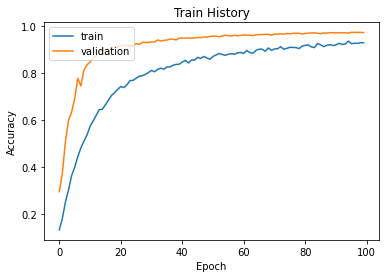

In [9]:
import matplotlib.pyplot as plt
plt.plot(a.history['accuracy'])
plt.plot(a.history['val_accuracy'])
plt.title('Train History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()





Thử nghiệm model

In [4]:
DATA_PATH = '/content/drive/MyDrive/DATA_TRAIN_FINAL/DATA_TRAIN_SI/'
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [10]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][np.argmax(model.predict(sample_reshaped))]

In [188]:
def wav2mfcc(file_path, max_len=20):
      myaudio = AudioSegment.from_file(file_path , "wav") 
      chunk_length_ms = 1000 # pydub calculates in millisec
      chunks = make_chunks(myaudio[0:1000], chunk_length_ms) #Make chunks of one sec

      #Export all of the individual chunks as wav files

      for i, chunk in enumerate(chunks):
        file_path = file_path
        print ("exporting", file_path)
        chunk.export(file_path, format="wav")
        
      sound = am.from_file(file_path, format='wav', frame_rate=22050)
      sound = sound.set_frame_rate(16000)
      sound.export(file_path, format='wav')

     

      
      # url = file_path
      # rate, data = wavfile.read(url)
      # data = data
      
      # noise_len = 1 # seconds
      # noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
      # noise_clip = noise[:rate*noise_len]
      # audio_clip_band_limited = data+noise
      
      # noise_reduced = nr.reduce_noise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, prop_decrease=1.0, verbose=True)
      # noise_reduced.export(file_path, format = "wav")

      wave, sr = librosa.load(file_path, mono=True, sr=None)

      wave = wave[::3]
      mfcc = librosa.feature.mfcc(wave, sr=16000)

      # If maximum length exceeds mfcc lengths then pad the remaining ones
      if (max_len > mfcc.shape[1]):
          pad_width = max_len - mfcc.shape[1]
          mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

      # Else cutoff the remaining parts
      else:
          mfcc = mfcc[:, :max_len]
      
      return mfcc

In [59]:
feature_dim_1 = 20
channel = 1
epochs = 100
batch_size = 100
verbose = 1
num_classes = 10

# Reshaping to perform 2D convolution
feature_dim_1=20
feature_dim_2 = 20

In [190]:
from keras.models import load_model

f = load_model('/content/drive/MyDrive/DATA_TRAIN_FINAL/weight2/weight2.h5')

print(predict('/content/sau2untitled.wav', f))

# get_labels(DATA_PATH)

exporting /content/sau2untitled.wav
sáu


In [ ]:
# pip install noisereduce

In [ ]:
# import IPython
# from scipy.io import wavfile
# import noisereduce as nr
# import soundfile as sf
# from noisereduce.generate_noise import band_limited_noise
# import matplotlib.pyplot as plt
# import urllib.request
# import numpy as np
# import io
# %matplotlib inline

In [119]:
# url = "/content/sau_1untitled.wav"
# rate, data = wavfile.read(url)
# data = data

In [ ]:
# IPython.display.Audio(data=data, rate=rate)

In [ ]:
# fig, ax = plt.subplots(figsize=(20,3))
# # ax.plot(data)

In [191]:
# noise_len = 1 # seconds
# noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
# noise_clip = noise[:rate*noise_len]
# audio_clip_band_limited = data+noise

In [ ]:
# fig, ax = plt.subplots(figsize=(20,3))
# ax.plot(audio_clip_band_limited)

In [ ]:
# noise_reduced = nr.reduce_noise(audio_clip=audio_clip_band_limited, noise_clip=noise_clip, prop_decrease=1.0, verbose=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(20,3))
# ax.plot(noise_reduced)

In [ ]:
# IPython.display.Audio(data=noise_reduced, rate=rate)